In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/study_1/data_full.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
data_list = []
for identifier, item in data.items():
    try:
        condition = item["log"]["condition"]
        date = item["date"]
        preference = item["log"]["preference"]
        age = item["log"]["age"]
        gender = item["log"]['gender']
        ux_list = item["log"]["ux"]
        for i, ux in enumerate(ux_list, start=1):
            row = {"identifier": identifier, "condition": condition, "preference": preference, "date": date, "age": age, "gender": gender}
            for j in range(1, 11):
                key = f"ux{j}"
                if key in ux:
                    row[f"ux{j}_{i}"] = ux[key]
                else:
                    row[f"ux{j}_{i}"] = None
            data_list.append(row)
    except KeyError:
        print(f"Skipping identifier {identifier} due to missing keys or empty 'ux' list.")

# Create the DataFrame
df = pd.DataFrame(data_list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-10']

In [4]:
df = df.groupby(['identifier', 'condition', 'preference', 'date', 'age', 'gender']).apply(lambda x: x.ffill().bfill())
df = df.drop_duplicates(subset=['identifier', 'condition', 'preference', 'date', 'age', 'gender'])
df.reset_index(drop=True, inplace=True)

In [7]:
# filtering the person who did not pay attention to anything
df = df[df['identifier'] != "5689069036109824"]

#filtering people with a mean 'cer' higher than 0.05 (identified in the main analysis)
identifiers_to_exclude = ['5689069036109824', '5139174843744256', '5672404563001344', '5699843028680704', '5748214695198720', '5751095477403648']
df = df[~df['identifier'].isin(identifiers_to_exclude)]
df.reset_index(drop=True, inplace=True)

In [10]:
print(df['gender'].value_counts())

male      58
female    56
other      1
Name: gender, dtype: int64


### sus

System Usability Scale score:
- For each of the odd numbered questions, subtract 1 from the score.
- For each of the even numbered questions, subtract their value from 5.
- Take these new values which you have found, and add up the total score. Then multiply this by 2.5.

In [12]:
# sus_1
ux_cols_1 = ['ux1_1', 'ux2_1', 'ux3_1', 'ux4_1', 'ux5_1', 'ux6_1', 'ux7_1', 'ux8_1', 'ux9_1', 'ux10_1']
odd_ux_cols_1 = ux_cols_1[::2]  # odd
even_ux_cols_1 = ux_cols_1[1::2]  # even

df['sus_1'] = df[odd_ux_cols_1].apply(lambda x: x - 1).sum(axis=1) + df[even_ux_cols_1].apply(lambda x: 5 - x).sum(axis=1) # subtract 1 from odd-numbered questions and subtract from 5 for even-numbered questions
df['sus_1'] = df['sus_1'] * 2.5 # multiply the total score by 2.5

# sus_2
ux_cols_2 = ['ux1_2', 'ux2_2', 'ux3_2', 'ux4_2', 'ux5_2', 'ux6_2', 'ux7_2', 'ux8_2', 'ux9_2', 'ux10_2']
odd_ux_cols_2 = ux_cols_2[::2]  # odd
even_ux_cols_2 = ux_cols_2[1::2]  # even

df['sus_2'] = df[odd_ux_cols_2].apply(lambda x: x - 1).sum(axis = 1) + df[even_ux_cols_2].apply(lambda x: 5 - x).sum(axis=1)
df['sus_2'] = df['sus_2'] * 2.5

In [13]:
df['sus_cognitive'] = df.apply(lambda row: row['sus_1'] if row['condition'] == 0 else row['sus_2'], axis=1)
df['sus_baseline'] = df.apply(lambda row: row['sus_1'] if row['condition'] == 1 else row['sus_2'], axis=1)

df = df[['identifier', 'condition', 'preference', 'sus_cognitive', 'sus_baseline']]

### tests

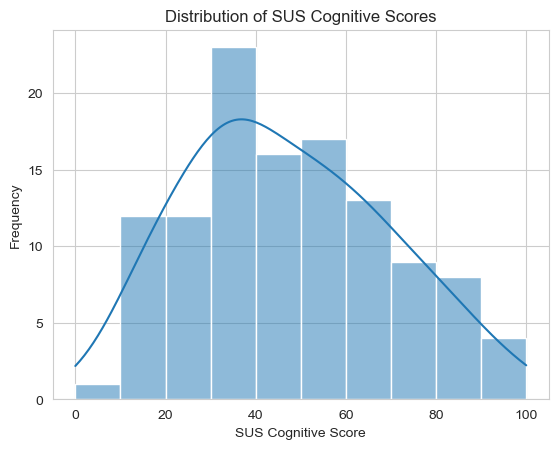

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='sus_cognitive', kde=True, bins=10)
plt.title('Distribution of SUS Cognitive Scores')
plt.xlabel('SUS Cognitive Score')
plt.ylabel('Frequency')
plt.show()

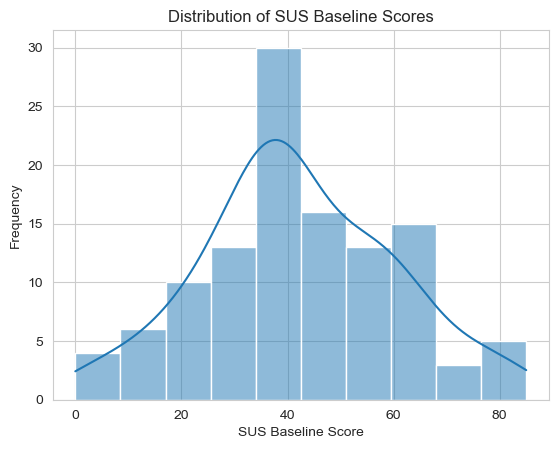

In [15]:
sns.histplot(data=df, x='sus_baseline', kde=True, bins=10)
plt.title('Distribution of SUS Baseline Scores')
plt.xlabel('SUS Baseline Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
from scipy.stats import ttest_rel

# Perform the paired t-test
t_stat, p_value = ttest_rel(df['sus_cognitive'], df['sus_baseline'])

# Calculate degrees of freedom
degrees_of_freedom_1 = len(df['sus_cognitive']) - 1

print("Paired t-test results:")
print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Degrees of Freedom (df1):", degrees_of_freedom_1)

if p_value < 0.05:
    if t_stat > 0:
        print("Cognitive group has a significantly higher mean.")
    else:
        print("Baseline group has a significantly higher mean.")
else:
    print("No significant difference between groups.")

Paired t-test results:
t-statistic: 2.802702289454583
p-value: 0.005956961653377298
Degrees of Freedom (df1): 114
Cognitive group has a significantly higher mean.


In [17]:
df['sus_cognitive'].describe()

count    115.000000
mean      46.847826
std       22.414768
min        0.000000
25%       30.000000
50%       45.000000
75%       62.500000
max      100.000000
Name: sus_cognitive, dtype: float64

In [18]:
df['sus_baseline'].describe()

count    115.000000
mean      41.956522
std       18.298759
min        0.000000
25%       30.000000
50%       40.000000
75%       55.000000
max       85.000000
Name: sus_baseline, dtype: float64

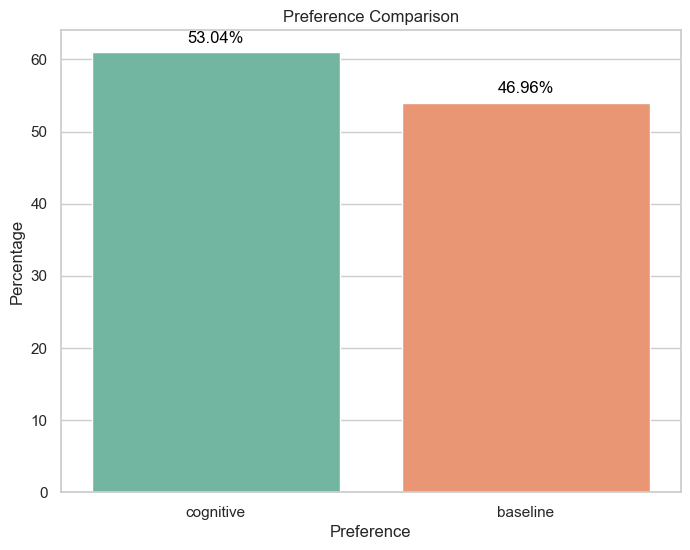

In [21]:
preference_counts = df['preference'].value_counts()
total_count = len(df)
percentages = (preference_counts / total_count) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='preference', data=df, palette='Set2')
ax.set_title('Preference Comparison')
ax.set_xlabel('Preference')
ax.set_ylabel('Percentage')

for p, percentage in zip(ax.patches, percentages):
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.show()

In [22]:
import statsmodels.api as sm
from scipy import stats

count_1 = preference_counts[1]
count_0 = preference_counts[0]
nobs = len(df['preference'])
z_stat, p_value = sm.stats.proportions_ztest([count_1, count_0], [nobs, nobs])

# Display the results of the proportion test
print("\nProportion Test Results:")
print("Z-statistic:", z_stat)
print("P-value:", p_value)

# Determine significance at a chosen alpha level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("\nReject the null hypothesis: The proportions are significantly different.")
else:
    print("\nFail to reject the null hypothesis: The proportions are not significantly different.")


Proportion Test Results:
Z-statistic: -0.9231326627541024
P-value: 0.3559380749284181

Fail to reject the null hypothesis: The proportions are not significantly different.


In [23]:
df.to_csv('df_sus.csv', index = False)